In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


In [22]:
H2_decisions = pd.read_csv('H-2-certification-decisions.csv')

//anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (0,8,9,14,15,16,17,18,20,21) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [23]:
H2_decisions.columns

Index(['case_no', 'visa_type', 'fy', 'last_event_date', 'case_status',
       'n_requested', 'n_certified', 'is_certified',
       'certification_begin_date', 'certification_end_date', 'job_title',
       'employer_name', 'employer_state', 'employer_city',
       'employer_address_1', 'employer_address_2', 'employer_postal_code',
       'worksite_state', 'worksite_city', 'agent_name', 'organization_flag',
       'is_duplicate'],
      dtype='object')

In [24]:
#calculate total case in each year,and total worker in each year. only need case_no, visa_type, fy, n_requested, n_certified,is_duplicated
col = ['case_no','visa_type','fy','n_requested','n_certified']
H2_decisions_clean = H2_decisions[col]
group_year_case =H2_decisions_clean.groupby(['fy','case_no'],as_index = False).sum()


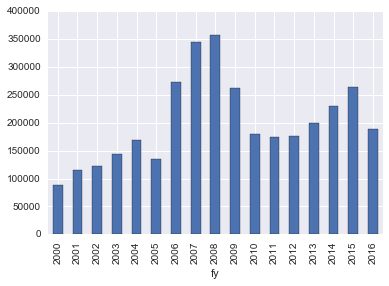

In [25]:
#total worker per year
yearly_worker = group_year_case.groupby('fy').sum()

plt.plot(yearly_worker['n_certified'])
yearly_worker['n_certified'].plot(kind = 'bar')

In [26]:
#total case per year
yearly_case = group_year_case.groupby('fy').count()


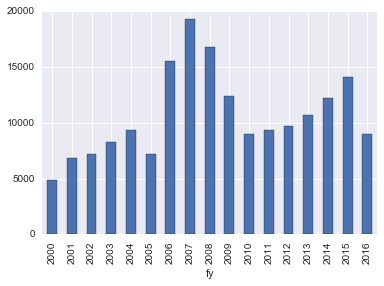

In [27]:
yearly_case['n_certified'].plot(kind = 'bar')

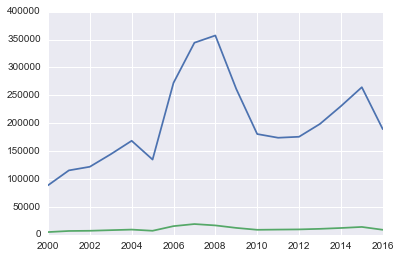

In [28]:
plt.plot(yearly_worker['n_certified'])
plt.plot(yearly_case['n_certified'])

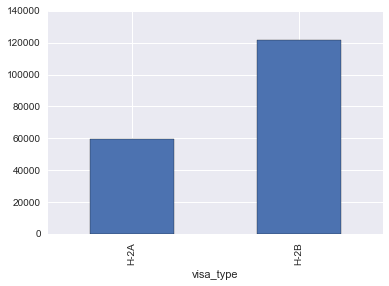

In [29]:
#How many different visa types and how many cases for each?
H2_decisions.columns
visa_type_count = H2_decisions['visa_type'].value_counts().count()
#number of visa types
visa_type_count
#number of cases for each type
visa_cases = H2_decisions_clean.groupby(['visa_type','case_no']).sum()
case_per_visa = visa_cases.groupby(level = 0).count()
case_per_visa['fy'].plot(kind = 'bar')

In [33]:
H2_decisions['case_status'].head()

0       DENIED, TEMPORARY
1    CERTIFIED, TEMPORARY
2    CERTIFIED, TEMPORARY
3    CERTIFIED, TEMPORARY
4    CERTIFIED, TEMPORARY
Name: case_status, dtype: object

In [35]:
#Create a new column with simplified values for easier analysis for case_status
#column cleaned_status: certified = 0,denied = 1,other = 2
all_status = H2_decisions['case_status'].value_counts().index.values
all_status 
status = {}
status['certified'] = [i for i in all_status if 'CERTI' in i]
status['denied'] = [i for i in all_status if 'DEN' in i]
status['others'] = [i for i in all_status if i not in status['certified'] and i not in status['denied']]
status

{'certified': ['CERTIFIED - FULL',
  'CERTIFIED',
  'CERTIFIED, TEMPORARY',
  'DETERMINATION ISSUED - CERTIFICATION',
  'CERTIFICATION',
  'PARTIAL CERTIFIED',
  'CERTIFIED - PARTIAL',
  'PARTIAL CERTIFICATION',
  'DETERMINATION ISSUED - CERTIFICATION EXPIRED',
  'CERTIFICATION EXPIRED',
  'DETERMINATION ISSUED - PARTIAL CERTIFICATION',
  'PARTIAL CERTIFICATION EXPIRED',
  'DETERMINATION ISSUED - PARTIAL CERTIFICATION EXPIRED'],
 'denied': ['DENIED',
  'DENIED, TEMPORARY',
  'DETERMINATION ISSUED - DENIED',
  'REDUCTION IN RECRUITMENT DENIED'],
 'others': ['WITHDRAWN',
  'RECEIVED REGIONAL OFFICE',
  'DETERMINATION ISSUED - WITHDRAWN',
  'INCOMPLETE',
  'RECEIVED',
  'REMAND TO SWA',
  'REMAND ISSUED TO EMPLOYER',
  'MODIFICATION',
  'REMAND ISSUED TO STATE',
  'DATA REVIEW',
  'FINAL REVIEW',
  'NOF ISSUED',
  'RETURNED BY EMP AFTER REMAND']}

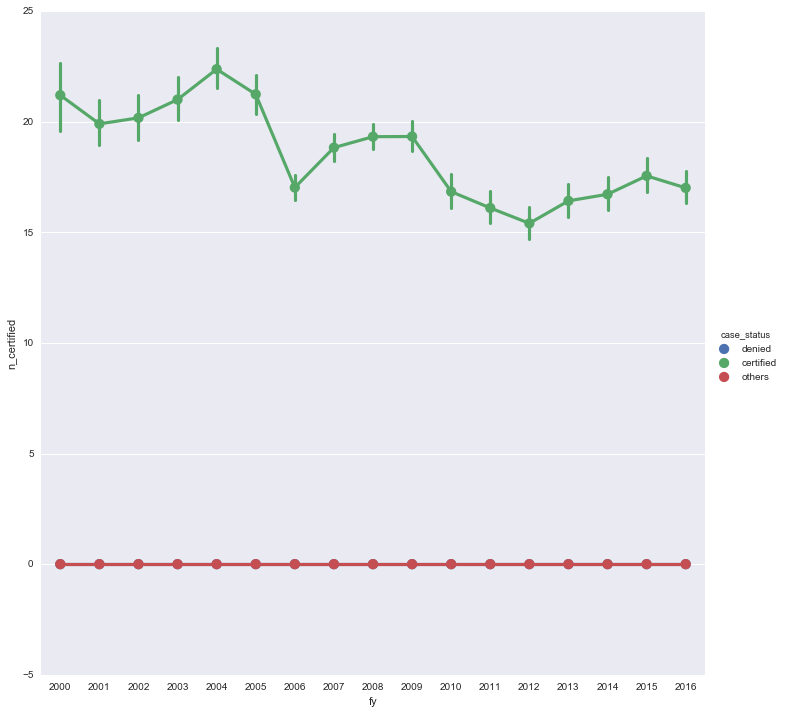

In [39]:
for key, value in status.items():    
    H2_decisions['case_status'].replace(value,key,inplace = True)
sns.factorplot(x = 'fy',y = 'n_certified',data=H2_decisions,hue = 'case_status',size = 10)

In [41]:
status_cleaned = H2_decisions['case_status'].value_counts().index.values.tolist()
status_mapping = {}
for i,status in enumerate(status_cleaned):
    status_mapping[status] = i
status_mapping['others']  = 100
H2_decisions['cleaned_status'] = H2_decisions['case_status'].map(status_mapping)
status_mapping
H2_decisions['cleaned_status'].head()

0    1
1    0
2    0
3    0
4    0
Name: cleaned_status, dtype: int64

In [42]:
#reclean the data with cleaned_status column
col = ['case_no','visa_type','fy','n_requested','n_certified','cleaned_status']
H2_decisions_clean = H2_decisions[col]

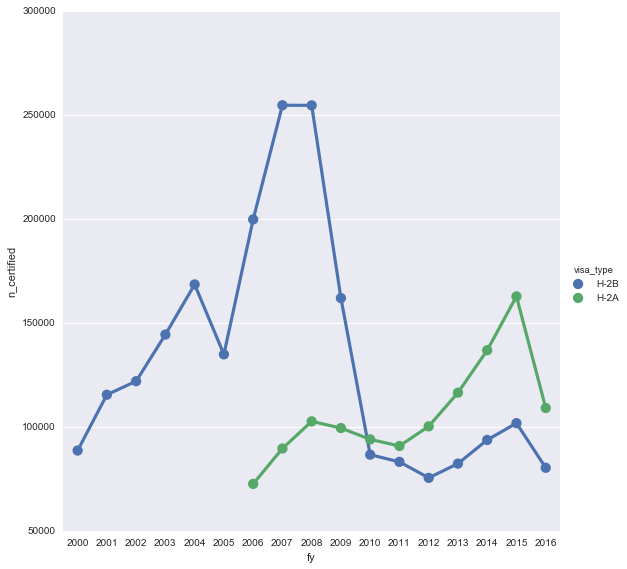

In [43]:
#n_requested - Calculate summary statistics and look for any outliers!
#how number of WORKERS with types of visa changes over the years
year_visatype_data_workers = H2_decisions_clean.groupby(['fy','visa_type'],as_index = False).sum()
sns.factorplot(x="fy", y="n_certified", hue="visa_type", data=year_visatype_data_workers,size = 8)


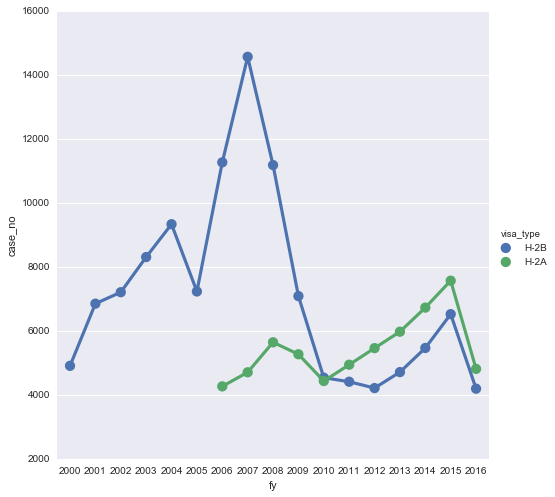

In [44]:
#how number of CASEs of each type of visa change over the year
case_year_type = H2_decisions_clean.groupby(['fy','visa_type','case_no'],as_index = False).count()
case_year_type = case_year_type.groupby(['fy','visa_type'],as_index = False).count()
sns.factorplot(x = 'fy',hue = 'visa_type',y = 'case_no',data = case_year_type,size = 7)


In [45]:
#calculate approval rate each year for each visa_type
year_visatype_data_workers_dropna = year_visatype_data_workers.dropna()
year_visatype_data_workers_dropna['approval_rate_workers'] = year_visatype_data_workers_dropna['n_certified']/year_visatype_data_workers_dropna['n_requested']
year_visatype_data_workers_dropna
year_visatype_data_workers['approval_rate_workers'] = year_visatype_data_workers['n_certified']/year_visatype_data_workers['n_requested']

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


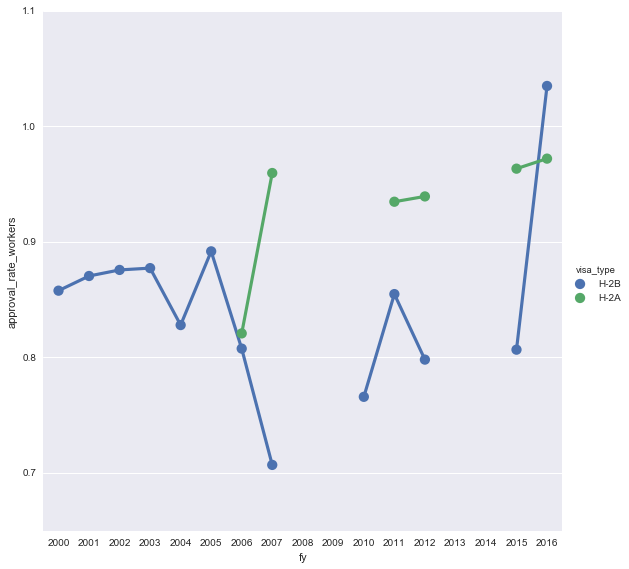

In [46]:
#plot approval rate for workers--separate visa
sns.factorplot(x = 'fy',y = 'approval_rate_workers',hue = 'visa_type',data =year_visatype_data_workers, size = 8)

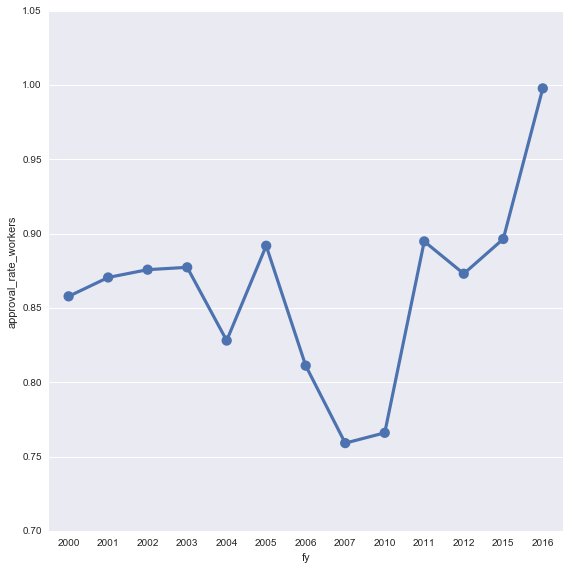

In [47]:
#plot approval rate for workers--total visa
year_visatype_data_workers_dropna_totalvisa = year_visatype_data_workers_dropna.groupby('fy', as_index = False).sum()
year_visatype_data_workers_dropna_totalvisa['approval_rate_workers'] = year_visatype_data_workers_dropna_totalvisa['n_certified']/year_visatype_data_workers_dropna_totalvisa['n_requested']
sns.factorplot(x = 'fy', y = 'approval_rate_workers',data = year_visatype_data_workers_dropna_totalvisa,size = 8)

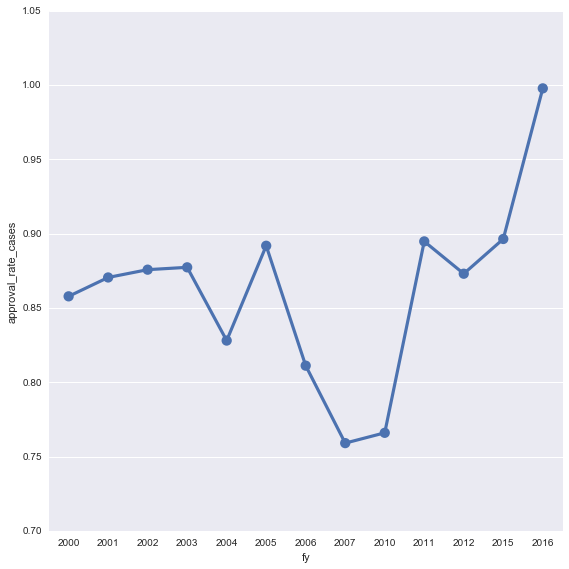

In [48]:
#case approval rate per year - total visa_type
year_visatype_data_workers_year = year_visatype_data_workers_dropna.groupby('fy',as_index = False).sum()
year_visatype_data_workers_year['approval_rate_cases'] = year_visatype_data_workers_year['n_certified']/year_visatype_data_workers_year['n_requested']
year_visatype_data_workers_year.drop('approval_rate_workers',axis = 1,inplace = True)
sns.factorplot(y = 'approval_rate_cases',x = 'fy',data =year_visatype_data_workers_year,size = 8)

In [49]:
#case approval rate per year - separate visa_type
H2_decisions_clean_case = H2_decisions_clean.groupby(['case_no','fy'],as_index = False).sum()
H2_decisions_clean_case.head()

,case_no,fy,n_requested,n_certified,cleaned_status
0,1283380,2000,1.0,1,0
1,1283837,2000,50.0,50,0
2,1283988,2000,45.0,45,0
3,1283989,2000,20.0,20,0
4,1284275,2000,1.0,0,1


In [50]:
all_years = H2_decisions['fy'].unique().tolist()
all_years

[2000,
 2001,
 2002,
 2003,
 2004,
 2005,
 2006,
 2007,
 2008,
 2009,
 2010,
 2011,
 2012,
 2013,
 2014,
 2015,
 2016]

In [51]:
#case approval rate per year - total visa_type
dic = {}
for year in all_years:
    data = group_year_case[group_year_case['fy'] == year]
    total = data.shape[0]
    certified = data[data['n_certified'] != 0].shape[0]
    dic[year] = certified/total
dic

{2000: 0.8505911129229515,
 2001: 0.8447948605635859,
 2002: 0.8372415706951575,
 2003: 0.8268721406212377,
 2004: 0.8063859423550841,
 2005: 0.8775933609958506,
 2006: 0.841993432489859,
 2007: 0.795215112356635,
 2008: 0.9212982226713428,
 2009: 0.8682911033756983,
 2010: 0.8695070265447246,
 2011: 0.8974331550802139,
 2012: 0.9142709410548087,
 2013: 0.9076102218477956,
 2014: 0.9117309269893356,
 2015: 0.8735093696763203,
 2016: 0.9059202488059536}

,fy,case_no,n_requested,n_certified
0,2000,1283380,1.0,1
1,2000,1283837,50.0,50
2,2000,1283988,45.0,45
3,2000,1283989,20.0,20
4,2000,1284275,1.0,0
5,2000,1284378,1.0,1
6,2000,1284379,1.0,1
7,2000,1284380,2.0,2
8,2000,1284381,2.0,0
9,2000,1284383,20.0,20


In [81]:
#case approval rate per year - separate visa_type
group_year_case_type =H2_decisions_clean.groupby(['fy','case_no','visa_type'],as_index = False).sum()
group_year_case_type
yearly_case_type = {}
for year in all_years:
    data = group_year_case_type[group_year_case_type['fy'] == year]
    data_visa = data[data['visa_type'] == 'H-2B']
    H2btotal = data_visa.shape[0]
    H2Bcertified = data_visa[data_visa['cleaned_status'] == 0].shape[0]
    H2brate = H2Bcertified/H2btotal
    data_visa_h2a = data[data['visa_type'] == 'H-2A']
    H2atotal = data_visa_h2a.shape[0]
    H2acertified = data_visa_h2a[data_visa_h2a['cleaned_status'] ==0].shape[0]
    if H2atotal == 0:
        H2arate = 0
    else:
        H2arate = H2acertified/H2atotal
    yearly_case_type[year] = H2arate,H2brate
    
yearly_case_type

{2000: (0, 0.8507949449653486),
 2001: (0, 0.8449408672798949),
 2002: (0, 0.8372415706951575),
 2003: (0, 0.8268721406212377),
 2004: (0, 0.8063859423550841),
 2005: (0, 0.8775933609958506),
 2006: (0.9134615384615384, 0.8149463033638058),
 2007: (0.9621598639455783, 0.7412976313079299),
 2008: (0.9292803970223326, 0.9173598068151328),
 2009: (0.9232959939244352, 0.8274061529777025),
 2010: (0.9205596930715414, 0.8216097023153253),
 2011: (0.9279498077312285, 0.8632342934905874),
 2012: (0.9668437442755083, 0.8461173118024222),
 2013: (0.9552988448016072, 0.8471337579617835),
 2014: (0.9628308058281296, 0.8488286969253295),
 2015: (0.9507070173120127, 0.7839288452691305),
 2016: (0.9617543130326336, 0.8416030534351145)}

In [100]:
#job_title-- How many different jobs represented? -- 8752
num_job_title = H2_decisions['job_title'].value_counts().count()
H2_decisions['job_title'].value_counts()

LABORER, LANDSCAPE                                    24595
CLEANER, HOUSEKEEPING                                  6563
FARMWORKERS AND LABORERS, CROP                         5354
FARMWORKER; DIVERSIFIED CROP                           5273
SHEEPHERDER                                            5258
LANDSCAPE LABORER                                      4942
STABLE ATTENDANT                                       4198
FARMWORKER, DIVERSIFIED CROP                           2978
FARMWORKER                                             2965
KITCHEN HELPER                                         2919
SHEEP HERDER                                           2894
CONSTRUCTION WORKER I                                  2651
CONSTRUCTION WORKER II                                 2472
GROUNDSKEEPER, INDUSTRIAL COMMERCIAL                   2457
FARM WORKERS & LABORERS, CROP                          2227
COOK                                                   2213
FARM WORKER; DIVERSIFIED CROPS II       

In [93]:
#organization_flag -- What are the different types of organizations and the distribution of values?
H2_decisions['organization_flag'].value_counts()

S                                            25085
Individual Employer                          14143
Association - Filing as Agent (H-2A Only)     3900
H-2A Labor Contractor or Job Contractor       2073
J                                              883
Association - Joint Employer (H-2A Only)       463
A                                              354
M                                              202
Association - Sole Employer (H-2A Only)         19
Name: organization_flag, dtype: int64

In [97]:
#Which locations and types of businesses request the most visas and how has this changed over time?
H2_decisions.columns
H2_decisions['worksite_state'].value_counts()

NC    14494
TX    11577
LA     9231
KY     8845
NY     7325
VA     7222
FL     6149
CO     5575
CA     5487
ID     5292
MA     4835
PA     3933
UT     3650
ND     3327
TN     3056
AZ     3021
NJ     2970
MT     2689
MD     2660
AR     2202
OH     2199
ME     2096
MO     2069
GA     2010
WY     1999
SD     1989
MS     1972
WA     1947
MI     1828
OK     1797
      ...  
SC     1357
CT     1266
NV     1210
AL     1169
IL     1156
VT     1079
NH      893
IA      671
NE      660
IN      606
AK      580
OR      549
DE      522
NM      461
WI      443
RI      348
WV      189
HI      165
DC       66
PR       50
VI        9
MP        8
KA        3
FM        3
GU        3
MH        2
SK        2
AS        2
AB        1
MB        1
Name: worksite_state, dtype: int64

In [102]:
from mpl_toolkits.basemap import Basemap
